# 様々な性能評価指標

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# ジュピターノートブック上でグラフを表示させるための処理
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import  f1_score

## Breast Cancer Wisconsinデータセットの読み込み

このデータセットには、悪性腫瘍細胞と良性腫瘍細胞の569のサンプルが含まれている。

このデータセットの最初の2つの列には、サンプルの一意なIDとそれに対応する診断結果が含まれている。診断結果の`M`は悪性(malignant)を示し、`B`は良性(benign)を示す。

3列目から32列目には、細胞核のデジタル画像から算出された30個の実数値の特徴量が含まれている。

これらは腫瘍が良性か悪性かを予測するモデルの構築に利用できる。

In [3]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
# 30個の特徴量をnumpy配列のオブジェクトXに割り当てる。
# LabelEncoderを使って、元のクラスラベルの文字列表現(MおよびB)を整数に変換する。
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
# 配列yに格納されたクラスラベル（診断結果）エンコードした後は、悪性腫瘍はクラス1、良性腫瘍はクラス2で表される。
y = le.fit_transform(y)
print(y[:5])
print(le.fit_transform(['M', 'B']))

# エンコード後のデータセットをトレーニングデータセット（データの80%）とテストデータセット（データの20%）に分割する。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

[1 1 1 1 1]
[1 0]


## 混同行列を解釈する

混同行列は、分類器の真陽性（true positive）、真陰性（true negative）、偽陽性(false positive)、偽陰性（false negative）の4つの予測の個数を報告する正方行列である。

真と偽は「予測が当たったかどうか」を表している。

陽性と陰性は「予測されたクラス」を表している。

たとえば、偽陽性は、予測されたクラスは陽性であったが、予測を間違えた（実は陰性だった）ことを表す。

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


[[71  1]
 [ 2 40]]


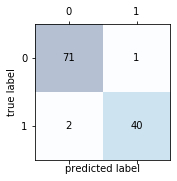

In [5]:
pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

pipe_svc.fit(X_train, y_train)

y_pred = pipe_svc.predict(X_test)

# テストと予測のデータから混同行列を生成
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

# 図のサイズを指定
fig, ax = plt.subplots(figsize=(2.5, 2.5))

# matshow関数で行列からヒートマップを描画
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]): # クラス0の繰り返し処理
    for j in range(confmat.shape[1]): # クラス1の繰り返し処理
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center') # 件数を表示

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

⬆︎

この例において、クラス1(悪性)を陽性であるとすれば、このモデルはクラス0に属するサンプルの71個(真陰性)と、クラス1に属するサンプルの40個(真陽性)を正しく分類している。

ただし、このモデルはクラス0の1つのサンプルをクラス1として誤分類しており（偽陽性）、悪性腫瘍である2つのサンプルを良性として予測している（偽陰性）。

この情報を使ってさまざまな誤差指標を計算する方法を考える。

## 分類モデルの適合率と再現率を最適化

予測の`誤分類率(ERR)`と`正解率(ACC)`は、誤分類されるサンプルの個数に関する全体的な情報を提供する。

誤分類率は、誤った予測の合計の予測の総数で割ったものとして解釈できる。
 - ERR = (FP + FN) / (FP + FN + TP + TN)

正解率は、正しい予測の合計を予測の総数で割ったものとして計算できる。
 - ACC = (TP + TN) / (FP + FN + TP + TN) = (1 - ERR)

`真陽性率(TPR)`と`偽陽性率(FPR)`は、不均衡なクラスの問題に特に役立つ性能指標である（以下のNは全陰性、Pは全陽性を表す）
 - TPR = TP / P = TP / (FN + TP) 
 - FPR = FP / N = FP / (FP + TN)

`適合率(PRE)`と`再現率(REC)`は、TPRとEPRに関連する性能指標である。実際には、RECはTPRの同義語である。
 - PRE = TP / (TP + FP)
 - REC = TPR = TP / P = TP / (FN + TP)

実際には、PREとRECを組み合わせた`F1スコア`と呼ばれるものがよく使用される。
 - F1 = 2 * ((PRE * REC) / (PRE + REC))

In [7]:
# 適合率、再現率、F1スコアを出力
print('Precision(適合率): %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall(再現率): %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1(F1スコア): %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision(適合率): 0.976
Recall(再現率): 0.952
F1(F1スコア): 0.964
